<a id='top'></a>
# Lyric Analysis

This notebook contains Natural Language Proccecing techniques used on Beatles lyrics to obtain insights into their songwriting. NLP techniques used include topic modelling using LDA and NMF clustering algorithms to identify the topics they wrote about, sentiment analysis using the textblob package to understand how thir songwriting evolved over the years, and word2vec to understand how entire songs and the words they used relate to one another.

This notebook can be run with any set of lyrics, if in the same format. Format will be the same if lyrics are obtained from a-z lyrics scraping notebook in this respository.

Contents:
- [Topic Modelling](#topics)</br>
    - [NMF](#nmf)</br>
    - [LDA](#lda)</br>
    - [Optimizing models](#optimal)</br>
- [Sentiment Analysis](#sent)</br>
    - [Album Sentiment (Sentiment over Time)](#albumsent)</br>
    - [Writer Sentiment](#writesent)</br>
- [word2vec](#wordvec)</br>
    - [2D plots](#twod)</br>
    - [3D plots](#threed)</br>
    - [Exporting labeled vectors to CSV](#csv)</br>


<br>
Last run with Python 3 on April 27th, 2017

### Setup

In [1]:
import pickle
import pandas as pd
import numpy as np
import difflib

from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from nltk.util import ngrams
from operator import itemgetter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF, LatentDirichletAllocation

from gensim import corpora, models, similarities, matutils

import seaborn as sns

import csv


# If needed...

#import nltk
#nltk.download()


%matplotlib inline

In [2]:
# Opening Pickle file

with open("df_beatles.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [3]:
# 'data' refers to the lyrics in each stanza, line, song

stanzas_gb = df.groupby(['song','stanza'])['lyric'].apply(lambda x: ' '.join(x))
stanzas = list(zip(stanzas_gb.keys(),stanzas_gb))
stanzas_data = [s[1] for s in stanzas]


lines_gb = df.groupby(['song','stanza','stanza_line'])['lyric'].apply(lambda x: ' '.join(x))
lines = list(zip(lines_gb.keys(),lines_gb))
lines_data = [s[1] for s in lines]


songs_gb = df.groupby(['song'])['lyric'].apply(lambda x: ' '.join(x))
songs = list(zip(songs_gb.keys(),songs_gb))
songs_data = [s[1] for s in songs]



In [4]:
# Helper functions


# Searches a dataframe for a specific item
def search_df(df,column,search):
    actual = difflib.get_close_matches(search, df[column])[0]
    return df.loc[df[column]==actual]

#search_df(df,'song','rocky racoon')



# Yields count of each word
def word_count(sections):
    count = defaultdict(int)
    for sect, lyric in sections:
        for word in lyric.split():
            if word not in stop:
                count[word]+=1
    return sorted(count.items(), key=itemgetter(1),reverse=True)

#print(word_count(stanzas))

<a id='topics'></a>
## Topic Modelling
[back to top](#top)<br>

In [5]:
n_topics = 3
n_features = 3
n_top_words = 10

stop = stopwords.words('english')
#stop += ['.', ',', '(', ')', "'", '"']

ngram_range = (1,1)



def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" %(topic_idx+1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    

    
def lda_features(data_samples,n_features=n_features,stop=stop,n_topics=n_topics,n_top_words=n_top_words,ngram_range=ngram_range):
    ct_vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stop)

    ct = ct_vectorizer.fit_transform(data_samples)
    
    print("Fitting LDA models with tf features...")

    lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)
    
    topic_vectors = lda.fit_transform(ct)
    topics = [list(r).index(max(r)) for r in topic_vectors]
    
    print("Topics in LDA model:")
    ct_feature_names = ct_vectorizer.get_feature_names()
    print_top_words(lda, ct_feature_names, n_top_words)
    return topics
                 

        
def nmf_features(data_samples,n_features=n_features,stop_words=stop,n_topics=n_topics, n_top_words=n_top_words):
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
    
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    
    print("Fitting NMF models with tf features...")
    nmf = NMF(n_components=n_topics, random_state=1,
              alpha=0, l1_ratio=.5)
    
    topic_vectors = nmf.fit_transform(tfidf)
    topics = [list(r).index(max(r)) for r in topic_vectors]

    print("Topics in NMF model:")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words)            
    return topics



def li_topic(df,topics):
    df_li = df.groupby(['song','song_line'],as_index=False).min()[['song','song_line']]
    df_li['topic'] = topics
    df_song_avg = df_li.groupby(['song'],as_index=False)[['topic']].mean()
    return df_li,df_song_avg



def stz_topic(df,topics):
    df_stz = df.groupby(['song','stanza'],as_index=False).min()[['song','stanza']]
    df_stz['topic'] = topics
    df_song_avg = df_stz.groupby(['song'],as_index=False)[['topic']].mean()
    return df_stz,df_song_avg

Testing to check which parsing method yields most comprehensive topics (by stanza, line, or song)

<a id='nmf'></a>
### NMF
[back to top](#top)<br>

In [6]:
# Stanza
print('{} topics from stanzas:'.format(n_topics))
nmf_stanza_topics = nmf_features(stanzas_data)
print('\n')

# Line
print('{} topics from lines:'.format(n_topics))
nmf_line_topics = nmf_features(lines_data)
print('\n')

# Song
print('{} topics from songs:'.format(n_topics))
nmf_song_topics = nmf_features(songs_data)

3 topics from stanzas:
Fitting NMF models with tf features...
Topics in NMF model:
Topic #1:
love need say always buy hold true whoa word till
Topic #2:
know want girl see time get like never go back
Topic #3:
oh yeah feeling got come ho back baby honey let



3 topics from lines:
Fitting NMF models with tf features...
Topics in NMF model:
Topic #1:
love need like say word buy still please hold baby
Topic #2:
yeah oh back tell please get whoa got ho believe
Topic #3:
know want say well mother let never bad tell see



3 topics from songs:
Fitting NMF models with tf features...
Topics in NMF model:
Topic #1:
girl know see want time mind go things get going
Topic #2:
love need true whoa never always long say oh please
Topic #3:
yeah oh come honey baby back got pie everybody ho



In [7]:
# df_nmf_stanza_topics    - yields the topic that each stanza belongs to
# df_nmf_song_topics_avg_stz  - yields the topic that each song belongs to, calcualted as the average of the topics by stanza

df_nmf_stanza_topics, df_nmf_song_topics_avg_stz = stz_topic(df,nmf_stanza_topics)

df_nmf_line_topics, df_nmf_song_topics_avg_li = li_topic(df,nmf_line_topics)

In [8]:
# Need to check these topics with the different topics printed out a couple of cells above this one

df_nmf_stanza_topics.head()

,song,stanza,topic
0,A Day in the Life,stanza_1,2
1,A Day in the Life,stanza_2,1
2,A Day in the Life,stanza_3,2
3,A Day in the Life,stanza_4,0
4,A Day in the Life,stanza_5,1


In [9]:
df_nmf_song_topics_avg_stz.head()

,song,topic
0,A Day in the Life,1.125000
1,A Hard Days Night,1.285714
2,A Taste of Honey,1.142857
3,Across the Universe,0.857143
4,Act Naturally,1.000000


In [10]:
print("Average song topic from stanzas:")
print(search_df(df_nmf_song_topics_avg_stz,'song','rocky racoon'))
print("\n")
print("Average song topic from lines:")
print(search_df(df_nmf_song_topics_avg_li,'song','rocky racoon'))

Average song topic from stanzas:
              song  topic
130  Rocky Raccoon  0.875


Average song topic from lines:
              song     topic
130  Rocky Raccoon  1.446809


<a id='lda'></a>
### LDA
[back to top](#top)<br>

In [11]:
# Stanza
print('{} topics from stanzas:'.format(n_topics))
lda_stanza_topics =  lda_features(stanzas_data)
print('\n')

# Line
print('{} topics from lines:'.format(n_topics))
lda_line_topics = lda_features(lines_data)
print('\n')

# Song
print('{} topics from songs:'.format(n_topics))
lda_song_topics = lda_features(songs_data)

3 topics from stanzas:
Fitting LDA models with tf features...
Topics in LDA model:
Topic #1:
yeah oh got come say time know see let get
Topic #2:
love know need like want much never oh tell hold
Topic #3:
yellow submarine good la live sun together mm one da



3 topics from lines:
Fitting LDA models with tf features...
Topics in LDA model:
Topic #1:
say see come time baby let back get good home
Topic #2:
know oh got girl like hey one go little hide
Topic #3:
love yeah yellow submarine need want away never long tell



3 topics from songs:
Fitting LDA models with tf features...
Topics in LDA model:
Topic #1:
back come yeah home good let bill bungalow honey one
Topic #2:
love know oh got see girl need want like tell
Topic #3:
yellow submarine live la much sun lonely sgt roll say



In [12]:
df_lda_stanza_topics, df_lda_song_topics_avg_stz = stz_topic(df,lda_stanza_topics)

df_lda_line_topics, df_lda_song_topics_avg_li = li_topic(df,lda_line_topics)

Comparing models

In [13]:
def compare_models_by_song(song_name,
                           nmf_stz_savg=df_nmf_song_topics_avg_stz,
                           nmf_li_savg=df_nmf_song_topics_avg_li,
                           lda_stz_savg=df_lda_song_topics_avg_stz,
                           lda_li_savg=df_lda_song_topics_avg_li):
    df1 = search_df(nmf_stz_savg,'song',song_name)
    df2 = search_df(nmf_li_savg,'song',song_name)
    df3 = search_df(lda_stz_savg,'song',song_name)
    df4 = search_df(lda_li_savg,'song',song_name)
    print('NMF Song Average from stanzas:')
    print(df1)
    print('\n')
    print('NMF Song Average from lines:')
    print(df2)
    print('\n')
    print('LDA Song Average from stanzas:')
    print(df3)
    print('\n')
    print('LDA Song Average from lines:')
    print(df4)
    print('\n')

In [14]:
# Again, need to check out what these topics are in the previous cells

compare_models_by_song('yellow submarine')

NMF Song Average from stanzas:
                 song  topic
171  Yellow Submarine  0.875


NMF Song Average from lines:
                 song     topic
171  Yellow Submarine  1.083333


LDA Song Average from stanzas:
                 song  topic
171  Yellow Submarine  1.875


LDA Song Average from lines:
                 song  topic
171  Yellow Submarine   1.75




<a id='optimal'></a>
### Optimal model
[back to top](#top)<br>

In [15]:
# Adjust n_tops, n_feats to fine-tune the topic modeling and find the best model

n_tops = 3
n_feats = 2

print('{} topics {} features from stanzas:'.format(n_tops,n_feats))
nmf_tuned = nmf_features(stanzas_data, n_topics=n_tops, n_features=n_feats)

3 topics 2 features from stanzas:
Fitting NMF models with tf features...
Topics in NMF model:
Topic #1:
love need say always buy hold true whoa word till
Topic #2:
know want girl see time get like never go back
Topic #3:
oh yeah feeling got come ho back baby honey let



### Takeaway

It appears that using NMF with 2 features and 3 topics produces the most cohesive topics. All are related to girls and love (not too surprising).

<b>Topic 1</b> appears to be <b>romantic, enduring love</b>.<br>
<b>Topic 2</b> appears to be <b>the loss of love</b>.<br>
<b>Topic 3</b> appears to be <b>more playful, youthful love</b>.<br>

<a id='sent'></a>
## Sentiment Analysis
[back to top](#top)<br>

In [16]:
from textblob import TextBlob

In [17]:
def song_sentiment(song_df):
    song_sent = []
    for i in range(len(song_df)):
        song, lyric = song_df.iloc[i]
        blob = TextBlob(lyric).sentiment
        song_sent.append([song,blob[0],blob[1]])
    cols = ['song','polarity','subjectivity']
    return (pd.DataFrame(song_sent,columns=cols))

In [18]:
df_songs = songs_gb.reset_index()

In [19]:
df_songSent = song_sentiment(df_songs)

In [20]:
df_songSent.head()

,song,polarity,subjectivity
0,A Day in the Life,0.141667,0.513384
1,A Hard Days Night,-0.039524,0.437619
2,A Taste of Honey,0.118750,0.241667
3,Across the Universe,0.096429,0.545238
4,Act Naturally,0.010794,0.375159


In [21]:
#df['release_date'] = pd.to_datetime(df['release_date'],format="%B %d %Y")
df['release_date'] = pd.to_datetime(df['release_date'],infer_datetime_format=True)

In [22]:
df2 = df.merge(df_songSent)

In [23]:
df.columns

Index(['album', 'release_date', 'song', 'writer', 'lead_singer', 'stanza',
       'stanza_line', 'song_line', 'lyric'],
      dtype='object')

In [24]:
df2.head()

,album,release_date,song,writer,lead_singer,stanza,stanza_line,song_line,lyric,polarity,subjectivity
0,Please Please Please Me,1963-03-22,I Saw Her Standing There,McCartney,McCartney,stanza_1,stanza_line_1,song_line_1,1 2 3 4,0.039123,0.455357
1,Please Please Please Me,1963-03-22,I Saw Her Standing There,McCartney,McCartney,stanza_2,stanza_line_1,song_line_2,well she was just 17,0.039123,0.455357
2,Please Please Please Me,1963-03-22,I Saw Her Standing There,McCartney,McCartney,stanza_2,stanza_line_2,song_line_3,you know what i mean,0.039123,0.455357
3,Please Please Please Me,1963-03-22,I Saw Her Standing There,McCartney,McCartney,stanza_2,stanza_line_3,song_line_4,and the way she looked was way beyond compare,0.039123,0.455357
4,Please Please Please Me,1963-03-22,I Saw Her Standing There,McCartney,McCartney,stanza_2,stanza_line_4,song_line_5,so how could i dance with another ooh,0.039123,0.455357


In [25]:
df2.groupby(['album'])['subjectivity'].mean()

album
A Hard Day's Night                       0.534381
Abbey Road                               0.551501
Beatles For Sale                         0.457301
Help!                                    0.470375
Let It Be                                0.392076
Magical Mystery Tour                     0.539953
Please Please Please Me                  0.524178
Revolver                                 0.477691
Rubber Soul                              0.477917
Sgt. Pepper's Lonely Hearts Club Band    0.528327
The Beatles (The White Album)            0.531015
With The Beatles                         0.495634
Yellow Submarine                         0.324296
Name: subjectivity, dtype: float64

<a id='albumsent'></a>
### Album Sentiment
[back to top](#top)<br>

In [26]:
df_sentiment_over_time = df2.groupby(['album','release_date'],as_index=False)['polarity'].mean()
df_sentiment_over_time.sort_values(by='release_date',inplace=True)
df_sentiment_over_time.reset_index(drop=True, inplace=True)

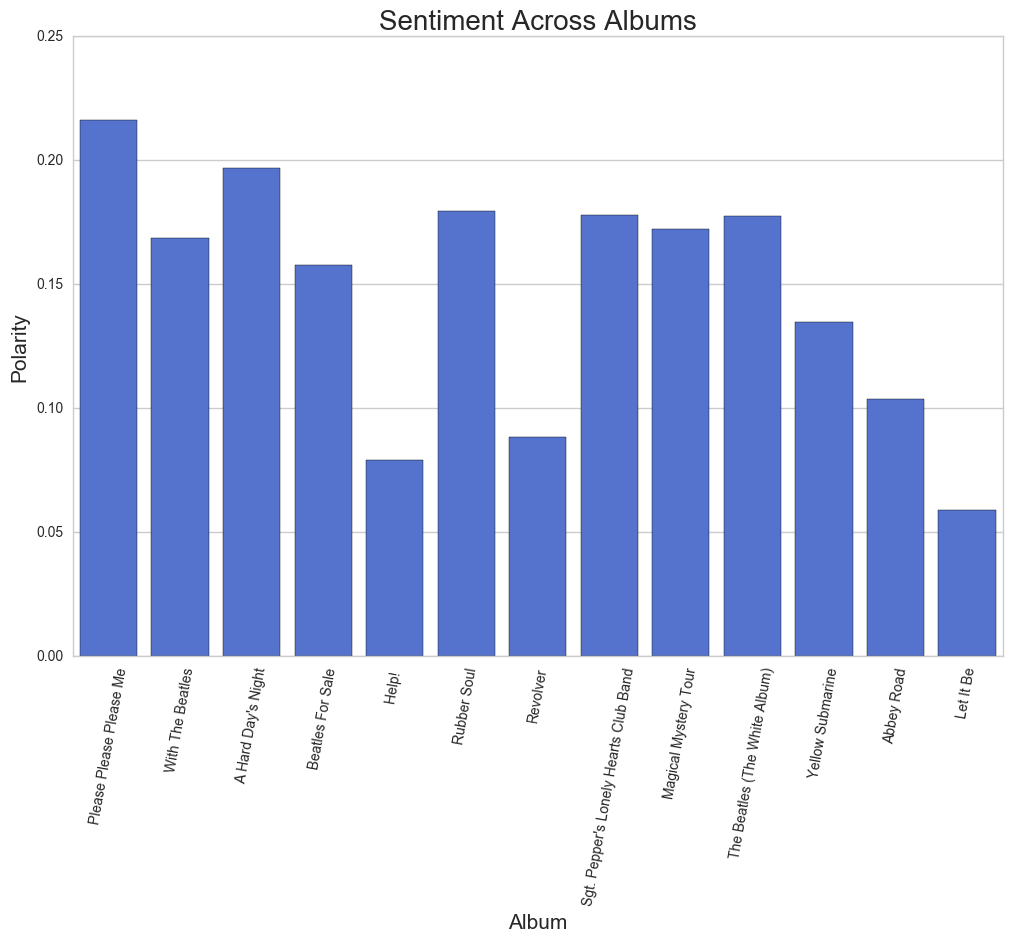

In [27]:
sns.set_style("whitegrid")
sns.plt.figure(figsize=(12, 8))
sns.plt.xticks(rotation=80)
ax = sns.barplot(x='album', y='polarity', data=df_sentiment_over_time,color='royalblue')
ax.set_title("Sentiment Across Albums",fontsize=20)
ax.set_xlabel("Album",fontsize=15)
ax.set_ylabel("Polarity",fontsize=15)

There appears to be a steady decline in the sentiment of Beatles lyrics throughout their tenure as a band. The exceptions being the negative sentment of the albums "Help!" and "Revolver". However, "Help!" was written as a soundtrack to a movie, so the sentiment might not accurately reflect the sentiment of the writers at the time, but instead reflect the sentiment intended for certain scenes.

<a id='writesent'></a>
### Writer Sentiment
[back to top](#top)<br>

In [28]:
df2 = df2.replace(to_replace='McCartney¾',value='McCartney')

In [29]:
df2.groupby(['writer'])['polarity'].mean()

writer
Alexander                                 0.300000
Berry                                     0.034625
Bradford/Gordy                            0.468750
David/Williams/Bacharach                  0.368182
Dixon/Farrell                             0.132500
Drapkin                                   0.333333
Goffin/King                               0.432051
Harrison                                  0.160111
Holland/Bateman/Garrett/Dobbins/Gorman    0.163636
Holly                                     0.304167
Johnson                                   0.441667
Leiber/Stoller/Penniman                  -0.164286
Lennon                                    0.118158
Lennon/McCartney                          0.134379
McCartney                                 0.160975
McCartney/Lennon                          0.400627
Medley/Russel                             0.111905
Morrison/Russel                           0.010794
Perkins                                   0.118022
Robinson                

In [30]:
# Getting sentiment of only John Lennon's and Paul McCartney's writing

df_writer_sentiment = df2.loc[df2['writer'].isin(['Lennon','McCartney'])]

In [31]:
df_writer_sentiment = df_writer_sentiment.groupby(['album','writer','release_date'],as_index=False)['polarity'].mean()
df_writer_sentiment.sort_values(by='release_date',inplace=True)
df_writer_sentiment.reset_index(drop=True, inplace=True)

In [32]:
df_writer_sentiment.groupby(['writer'])['polarity'].mean()

writer
Lennon       0.097393
McCartney    0.172596
Name: polarity, dtype: float64

In [33]:
# Each Writer's sentiment by album

df_writer_sentiment

,album,writer,release_date,polarity
0,Please Please Please Me,Lennon,1963-03-22,0.135561
1,Please Please Please Me,McCartney,1963-03-22,0.316375
2,With The Beatles,Lennon,1963-11-22,0.037851
3,With The Beatles,McCartney,1963-11-22,0.242948
4,A Hard Day's Night,Lennon,1964-06-26,0.154058
5,A Hard Day's Night,McCartney,1964-06-26,0.333866
6,Beatles For Sale,McCartney,1964-12-04,0.321253
7,Beatles For Sale,Lennon,1964-12-04,0.111197
8,Help!,Lennon,1965-08-06,0.110822
9,Help!,McCartney,1965-08-06,0.070123


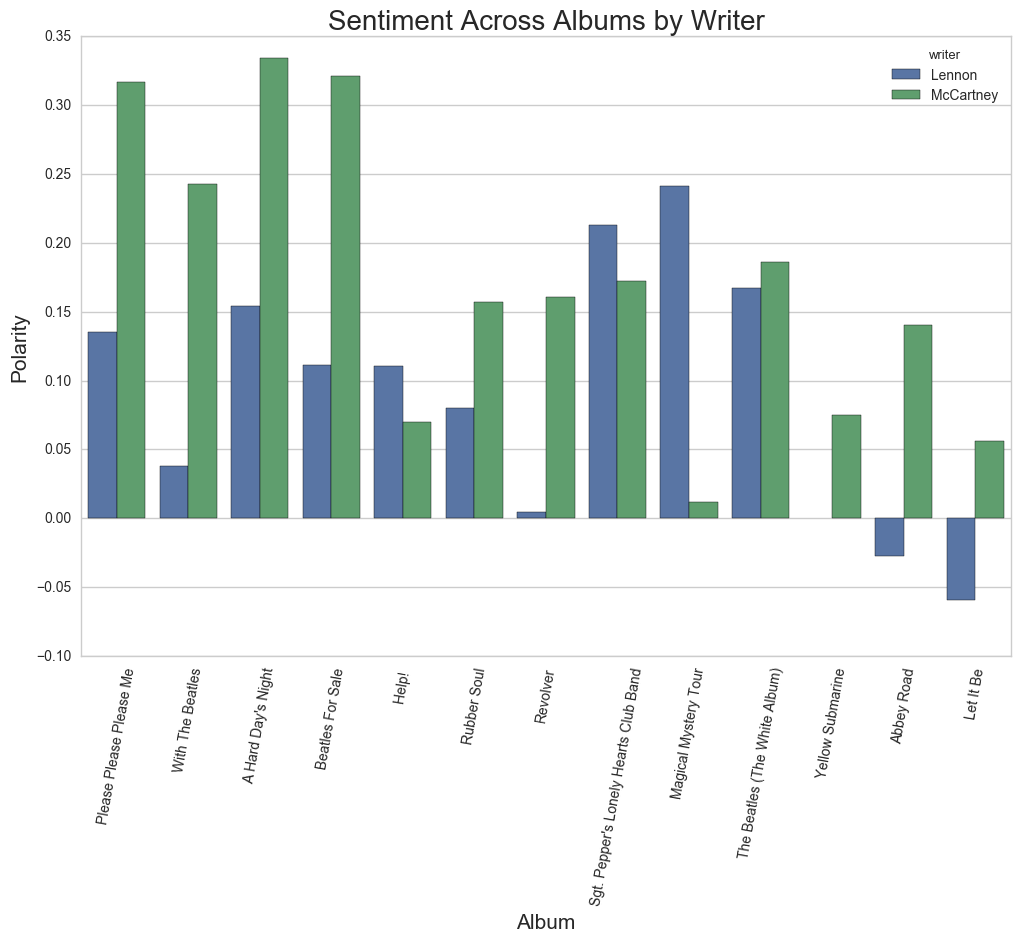

In [34]:
sns.set_style("whitegrid")
sns.plt.figure(figsize=(12, 8))
sns.plt.xticks(rotation=80)
ax = sns.barplot(x="album", y="polarity", hue="writer", data=df_writer_sentiment)
ax.set_title("Sentiment Across Albums by Writer",fontsize=20)
ax.set_xlabel("Album",fontsize=15)
ax.set_ylabel("Polarity",fontsize=15)

In [35]:
df_song_sentiment = df2.groupby(['album','song','writer'],as_index=False)[['polarity']].mean()

In [36]:
# Song sentiment, sorted from most NEGATIVE to most POSITIVE

df_song_sentiment.sort_values(by='polarity',inplace=True)
df_song_sentiment.reset_index(drop=True, inplace=True)
df_song_sentiment.head(20)

,album,song,writer,polarity
0,Abbey Road,I Want You (Shes So Heavy),Lennon,-0.536364
1,The Beatles (The White Album),Im So Tired,Lennon,-0.425000
2,Let It Be,One After 909,Lennon,-0.310714
3,Let It Be,Maggie Mae,Trad. arr.,-0.243651
4,Beatles For Sale,Everybodys Trying to Be My Baby,Perkins,-0.179167
5,With The Beatles,Little Child,Lennon/McCartney,-0.171014
6,Beatles For Sale,"Medley: Kansas City/Hey, Hey, Hey, Hey",Leiber/Stoller/Penniman,-0.164286
7,The Beatles (The White Album),Yer Blues,Lennon,-0.161905
8,Revolver,And Your Bird Can Sing,Lennon,-0.145679
9,Abbey Road,Mean Mr Mustard,Lennon,-0.125833


In [37]:
# Song sentiment, sorted from most POSITIVE to most NEGATIVE

df_song_sentiment.sort_values(by='polarity',ascending=False,inplace=True)
df_song_sentiment.reset_index(drop=True, inplace=True)
df_song_sentiment.head(20)

,album,song,writer,polarity
0,Abbey Road,Sun King,Lennon,0.800000
1,The Beatles (The White Album),Birthday,McCartney,0.666667
2,With The Beatles,Till There Was You,Wilson,0.616667
3,Revolver,Good Day Sunshine¾,McCartney,0.582847
4,Sgt. Pepper's Lonely Hearts Club Band,Good Morning Good Morning,Lennon,0.554873
5,Abbey Road,Octopuss Garden,Starkey,0.523611
6,Revolver,"Here, There and Everywhere",McCartney,0.522222
7,The Beatles (The White Album),Happiness is a Warm Gun,Lennon,0.514478
8,Rubber Soul,Drive My Car,McCartney,0.503042
9,Abbey Road,Polythene Pam,Lennon,0.500000


Interestingly, but perhaps not too surprisingly, John Lennon seems to have written more of the negative songs than McCartney, and McCartney seems to have written more of the postive songs.

<a id='wordvec'></a>
## word2vec & Dimension Reduction
[back to top](#top)<br>

In [38]:
import gensim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [39]:
#stanzas_data

texts = [[word for word in document.split() if word not in stop]
         for document in stanzas_data]

In [40]:
w2v = gensim.models.Word2Vec(texts, size=100, window=5, min_count=1, workers=2,sg=1)

# Working in 100 dimensional space here (size=100)

#w2v.vocab
#w2v.index2word

In [41]:
w2v.most_similar('love' ,topn=5)

[('need', 0.9974937438964844),
 ('yee', 0.9834351539611816),
 ('hai', 0.9810878038406372),
 ('loves', 0.9558262825012207),
 ('hold', 0.9520334601402283)]

In [42]:
w2v.most_similar('yellow' ,topn=5)

[('submarine', 0.9996851682662964),
 ('live', 0.9981018304824829),
 ('green', 0.9975156188011169),
 ('sea', 0.9922900199890137),
 ('jones', 0.9813241362571716)]

In [43]:
w2v.most_similar(['yellow','sgt'],['submarine'],topn=5)

[('pepper', 0.9989845156669617),
 ('band', 0.9960166215896606),
 ('hearts', 0.9959182739257812),
 ('lonely', 0.9956749677658081),
 ('club', 0.9951004981994629)]

In [44]:
w2v.most_similar(['yellow','help'],['submarine'],topn=5)

[('friends', 0.9891432523727417),
 ('little', 0.9855713844299316),
 ('road', 0.983980655670166),
 ('high', 0.9807602763175964),
 ('try', 0.9789062738418579)]

In [45]:
# Similarity
w2v.similarity('woman','man')

0.92251665470173116

In [46]:
# Compute cosine_similarity
w2v.n_similarity(['woman', 'girl'], ['man', 'boy'])

0.97226246239289182

In [47]:
# Values for each dimension of the 'love' vector

print(len(w2v['love']))
print('\n')
print(w2v['love'])

100


[ -4.34877604e-01  -1.26854852e-01   2.01591104e-01  -1.44003257e-01
   6.31326362e-02   5.85623756e-02   3.65321673e-02  -1.88571617e-01
  -2.63863772e-01  -8.49841721e-03  -3.30323845e-01   2.47003391e-01
   3.19587469e-01  -4.47206855e-01  -4.81637288e-03  -4.72861648e-01
   2.86361992e-01   3.41397487e-02   2.75570173e-02   1.56455696e-01
   4.82926071e-01   4.71554324e-02  -5.68304121e-01  -2.75698662e-01
  -3.02168220e-01   1.72468106e-04  -1.03076257e-01   4.67876047e-01
   2.92979717e-01  -1.39945358e-01   2.79929578e-01   3.82657498e-01
   5.45805037e-01  -2.34836429e-01  -2.44640440e-01  -4.79150623e-01
   3.22035819e-01   2.56302327e-01   2.20306396e-01   2.61446476e-01
  -1.89826280e-01  -2.03917533e-01   8.62254575e-02   6.04316711e-01
   7.56216943e-02  -3.07201743e-02  -1.28028363e-01  -4.16452974e-01
   3.78578663e-01  -3.08134198e-01   3.30331951e-01  -2.40944803e-01
  -6.72101304e-02  -2.07071245e-01   1.61759928e-01  -3.32465470e-01
   3.81859213e-01   1.047661

In [48]:
# More helpful storage of the word vectors

word_vectors = []
for word in w2v.index2word:
    word_array = []
    for i in range(len(w2v[word])):
        word_array.append(w2v[word][i])
    word_vectors.append(word_array)
    

In [49]:
print(len(word_vectors))
print(len(word_vectors[0]))
print(len(w2v.vocab))

2121
100
2121


In [50]:
def dim_reduct_pca_tsne(word_vectors,pca_components=25,tsne_components=2,plot=False):
    pca_x = PCA(n_components=pca_components)
    wordVecs_pca = pca_x.fit_transform(word_vectors)
    
    tsne_x = TSNE(n_components=tsne_components, random_state=0)
    wordVecs = tsne_x.fit_transform(wordVecs_pca)
    
    
    #basic plot to see shape of vector space
    if plot==True:
        sns.plt.figure(figsize=(20,12))
        sns.plt.plot(wordVecs[:,0], wordVecs[:,1], 'o')
        sns.plt.xlim(-20.0, 20.0)  
        sns.plt.ylim(-20.0, 20.0)
    
    return wordVecs

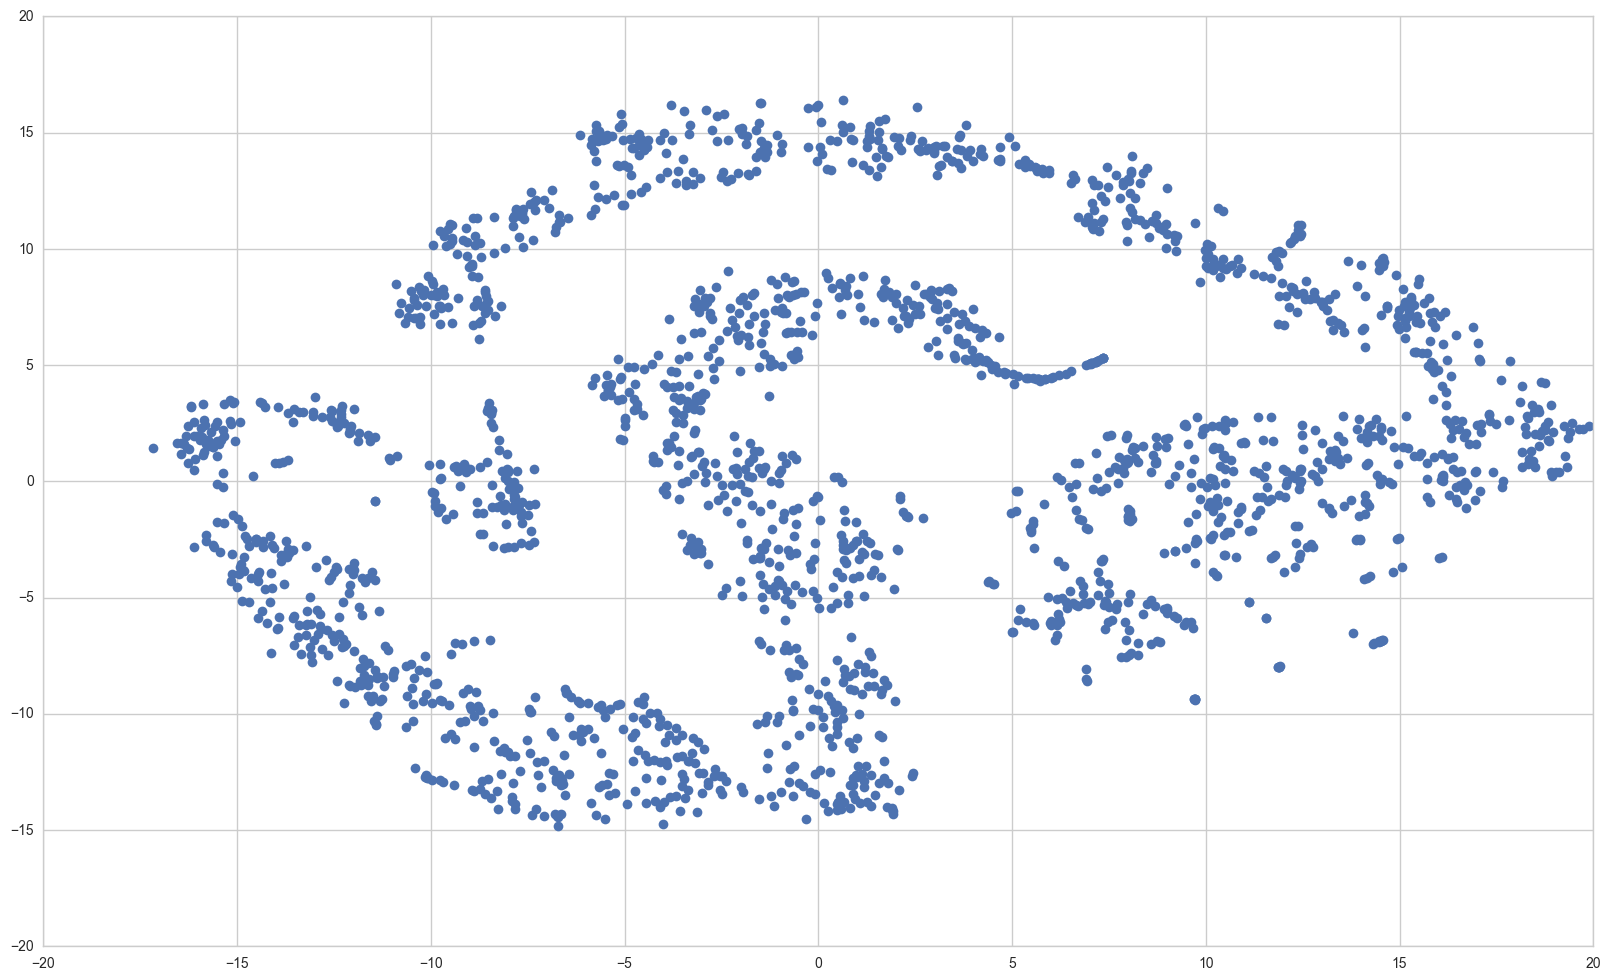

In [51]:
word_vecs_25_2 = dim_reduct_pca_tsne(word_vectors,plot=True)

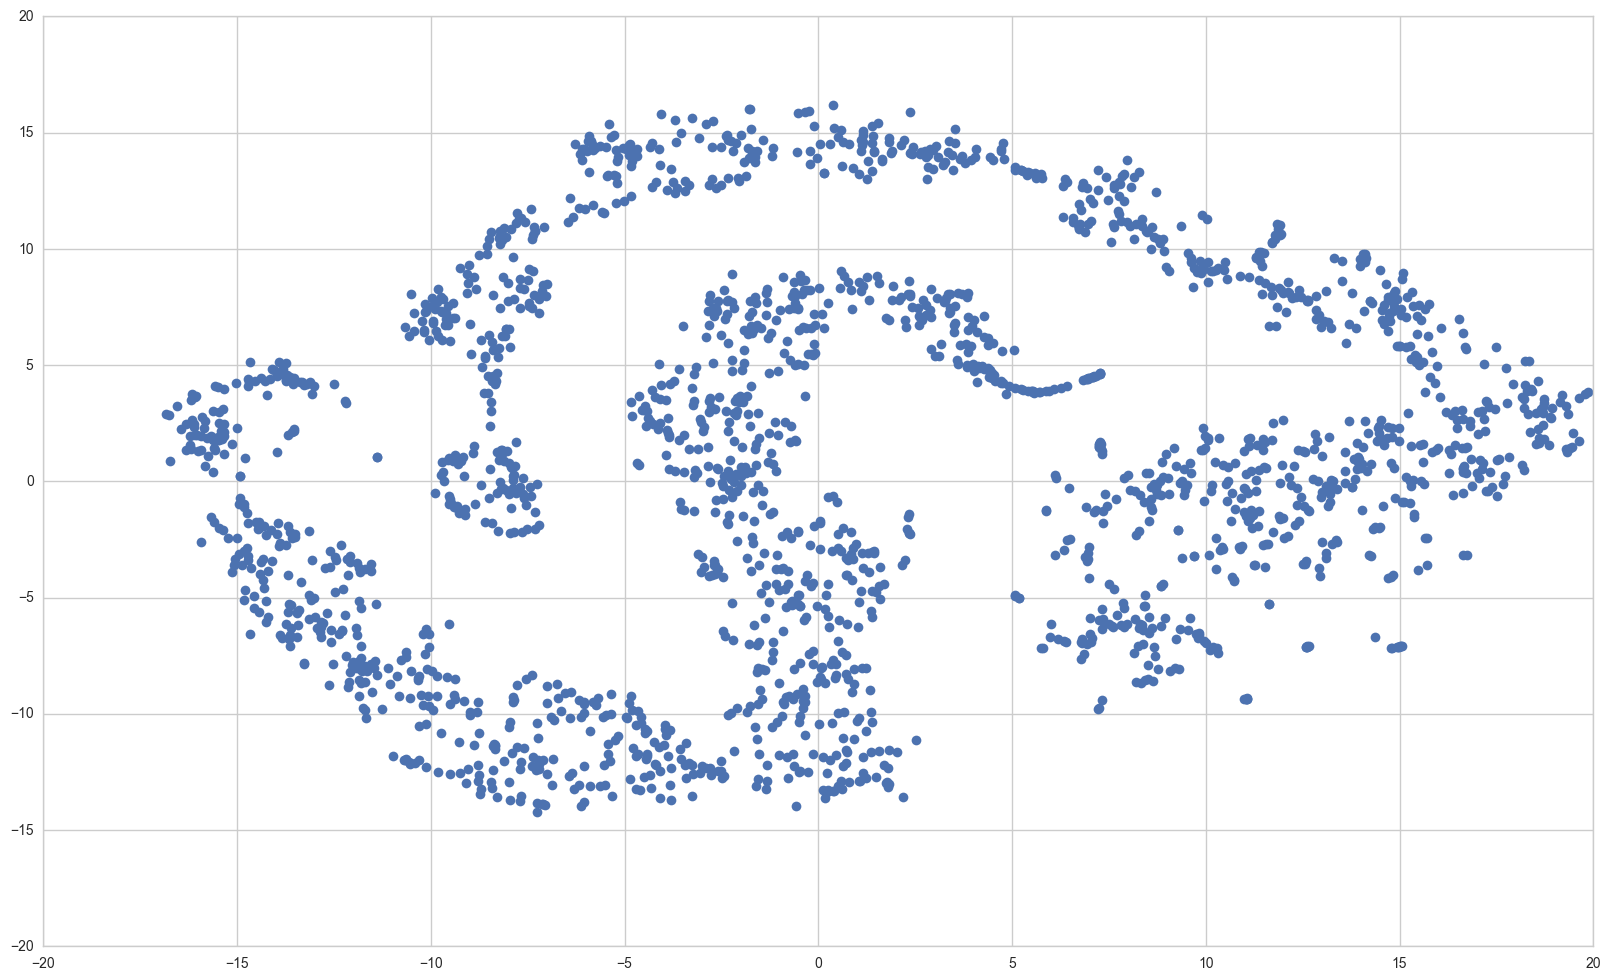

In [52]:
word_vecs_50_2 = dim_reduct_pca_tsne(word_vectors,pca_components=50,tsne_components=2,plot=True)

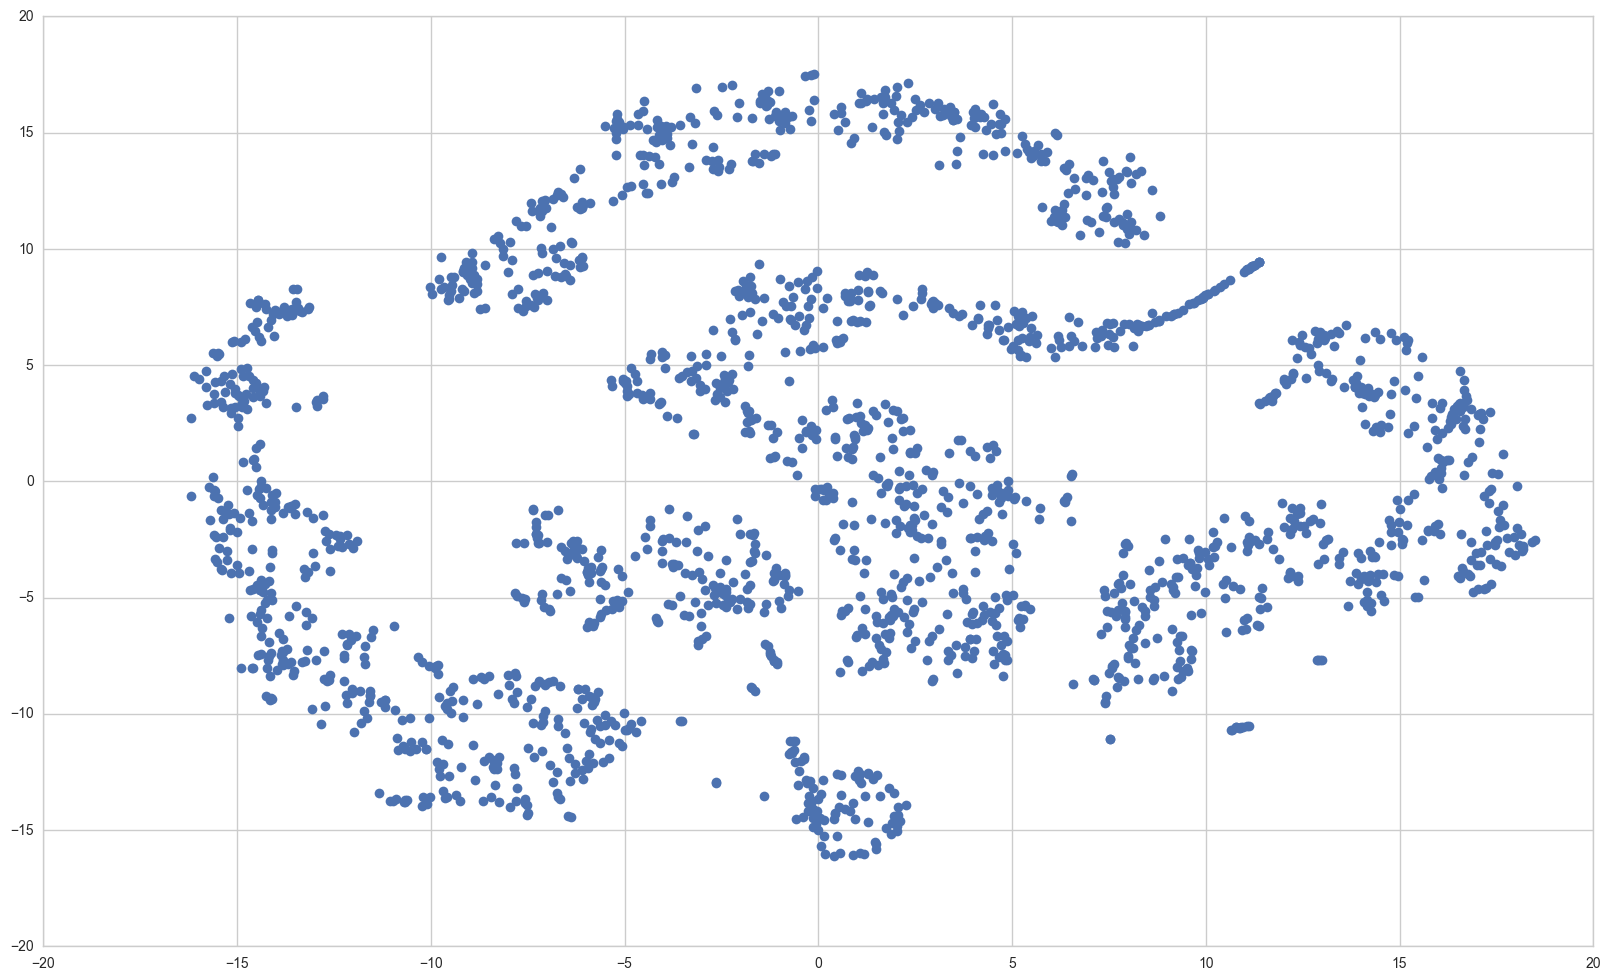

In [53]:
word_vecs_5_2 = dim_reduct_pca_tsne(word_vectors,pca_components=5,tsne_components=2,plot=True)

In [54]:
# Word count dictionary for plots

# Dictionary Format:
#   song:(word,tfidf_value)


song_word_count_dict = {}
for i in range(len(songs)):
    count_dict = defaultdict(int)
    for word in songs[i][1].split():
        count_dict[word]+=1
    song_word_count_dict[songs[i][0]] = count_dict

In [55]:
song_word_count_dict[songs[0][0]]['many']

1

In [56]:
song_word_count_dict['A Day in the Life']

defaultdict(int,
            {'a': 9,
             'about': 1,
             'across': 1,
             'ah': 1,
             'albert': 1,
             'all': 1,
             'and': 9,
             'army': 1,
             'away': 1,
             'bed': 1,
             'before': 1,
             'blackburn': 1,
             'blew': 1,
             'book': 1,
             'boy': 3,
             'bus': 1,
             'but': 1,
             'car': 1,
             'changed': 1,
             'coat': 1,
             'comb': 1,
             'count': 1,
             'crowd': 2,
             'cup': 1,
             'd': 3,
             'didn': 1,
             'downstairs': 1,
             'dragged': 1,
             'drank': 1,
             'dream': 1,
             'english': 1,
             'face': 1,
             'fell': 1,
             'fill': 1,
             'film': 1,
             'flat': 1,
             'found': 3,
             'four': 1,
             'from': 1,
             'grabbed': 1,
    

In [57]:
# TFIDF values for plot (and other things, if you want)

tfidf_vectorizer = TfidfVectorizer(stop_words=stop)
song_tfidf = tfidf_vectorizer.fit_transform(songs_data)

In [58]:
song_tfidf.indices

array([1433, 1229, 1862, ..., 1721,  695,  337], dtype=int32)

In [59]:
tfidf_word_index = list(zip(tfidf_vectorizer.get_feature_names(),song_tfidf.indices))

In [60]:
# Dictionary Format:
#   song:(word,tfidf_value)


song_word_tfidf_dict = {}
for i in range(len(songs)):
    tf_dict = defaultdict(int)
    sname = songs[i][0]
    ly = songs[i][1].split()
    for w in ly:
        for j in range(len(tfidf_word_index)):
            if w == tfidf_word_index[j][0]:
                tf_dict[w]+=song_tfidf.toarray()[i][tfidf_word_index[j][1]]
    song_word_tfidf_dict[songs[i][0]]=tf_dict


In [61]:
song_word_tfidf_dict[songs[0][0]]['many']

0.0

In [62]:
song_word_tfidf_dict['A Day in the Life']

defaultdict(int,
            {'across': 0.091526541548020743,
             'ah': 0.057552541067317428,
             'albert': 0.091526541548020743,
             'army': 0.091526541548020743,
             'away': 0.0,
             'bed': 0.0,
             'blackburn': 0.0,
             'blew': 0.0,
             'book': 0.0,
             'boy': 0.27457962464406221,
             'bus': 0.0,
             'car': 0.0,
             'changed': 0.073961656997340752,
             'coat': 0.0,
             'comb': 0.0,
             'count': 0.0,
             'crowd': 0.0,
             'cup': 0.0,
             'downstairs': 0.0,
             'dragged': 0.0,
             'drank': 0.0,
             'dream': 0.057552541067317428,
             'english': 0.0,
             'face': 0.0,
             'fell': 0.0,
             'fill': 0.0,
             'film': 0.0,
             'flat': 0.0,
             'found': 0.0,
             'four': 0.0,
             'grabbed': 0.0,
             'grade': 0.0,
       

In [63]:
w2v_words = w2v.index2word

<a id='twod'></a>
### 2D word2vec plots
[back to top](#top)<br>

In [64]:
# More refined plots...
#   - highlight single word
#   - show up to 2 songs
#   - option of TF-IDF for one plot


def plot_word_vecs(word_vectors, words,
                   song_word_count_dict=song_word_count_dict,
                   song_word_tfidf_dict=song_word_tfidf_dict,
                   word_search=None,
                   song_search=None,
                   tfidf=False,
                   count=False):
    
    sns.plt.figure(figsize=(20,12))
    sns.plt.plot(word_vectors[:,0], word_vectors[:,1], 'o', color=(0.05,0.05,0.4,0.3))
    sns.plt.xlim(-20.0, 20.0)  
    sns.plt.ylim(-20.0, 20.0)
    
    print("Song Search: ", bool(song_search))
    if song_search:
        if type(song_search)==str:
            song_search = [song_search]
        if len(song_search)>2:
            return "Two songs max... c'mon"

        colors = ['red','yellow']
        
        songs = list(song_word_count_dict.keys())
        for i in range(len(song_search)):
            matches = difflib.get_close_matches(song_search[i], songs, cutoff=.3)
            if matches:
                song_search[i]=matches[0]
            else:
                song_search[i]=None
        if song_search[0]:
            song_1_words = [word for word in song_word_count_dict[song_search[0]]]
        else:
            song_1_words = []
    
        
        
        for i in range(len(song_search)):
            if not song_search[i]:
                print("   No match found for song {}".format(i+1))
                print("\n")
                continue
            print("   Song {}:".format(i+1), song_search[i])
            print("    color:", colors[i])
            for song_word in song_word_count_dict[song_search[i]]:
                for word, x, y in zip(words, word_vectors[:,0], word_vectors[:,1]):
                    if song_word==word:
                        if i==1 and song_word in song_1_words:
                            sns.plt.plot(x, y, marker='o', color="orange", markersize=(12))
                        elif tfidf:
                            sns.plt.plot(x, y, marker='o', color=colors[i], markersize=(6+(song_word_tfidf_dict[song_search[i]][song_word])*100))
                        elif count:
                            sns.plt.plot(x, y, marker='o', color=colors[i], markersize=(6+(song_word_count_dict[song_search[i]][song_word])*5))
                        else:
                            sns.plt.plot(x, y, marker='o', color=colors[i], markersize=(12))
                        sns.plt.annotate(word, (x, y), size=12)
            print("\n")
            
    print("\n")
                        
    print("Word Search: ", bool(word_search))
    if word_search:
        if type(word_search)==str:
            word_search = [word_search]
        for word_search_word in word_search:
            print("   Word:", word_search_word)
            match=False
            for word, x, y in zip(words, word_vectors[:,0], word_vectors[:,1]):
                if word == word_search_word:
                    match=True
                    sns.plt.plot(x, y, marker='o', color='purple', markersize=(12))
                    sns.plt.annotate(word, (x, y), size=12)
            print("   Match: ", match)
            print("\n")


Song Search:  True
   Song 1: A Day in the Life
    color: red


   Song 2: Yellow Submarine
    color: yellow




Word Search:  True
   Word: submarine
   Match:  True


   Word: yellow
   Match:  True




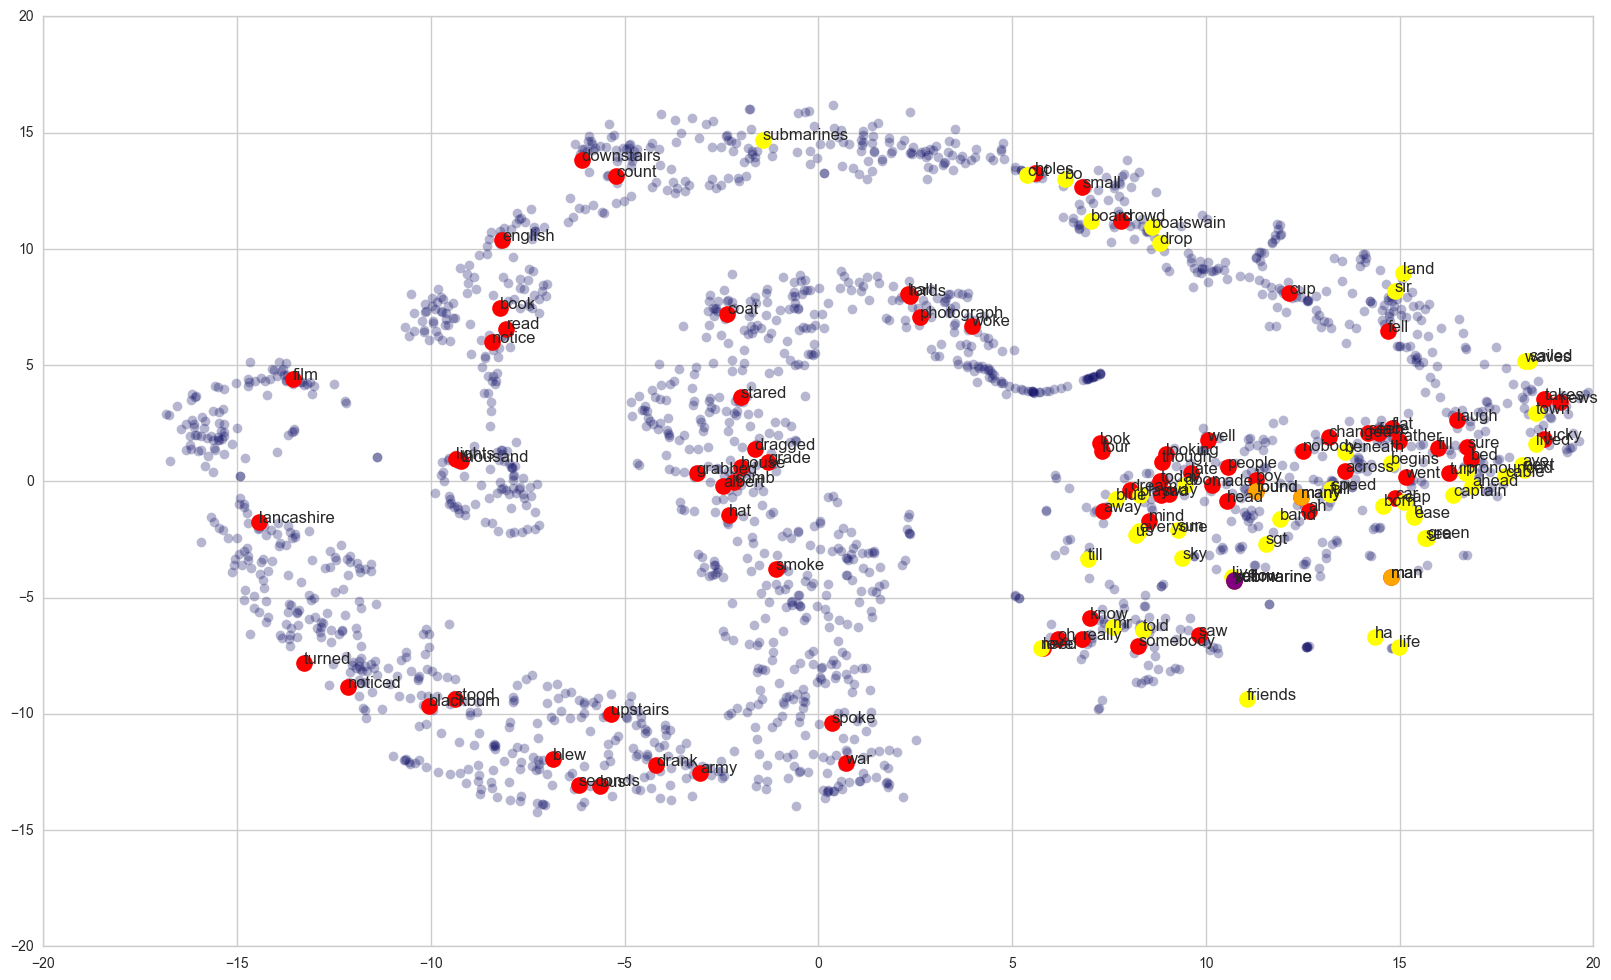

In [65]:
plot_word_vecs(word_vecs_50_2,w2v_words,word_search=['submarine','yellow'],song_search=['a day in the lift','yellow submarine'])

Tf-Idf scaled points

Song Search:  True
   Song 1: Yellow Submarine
    color: red




Word Search:  True
   Word: submarine
   Match:  True


   Word: yellow
   Match:  True




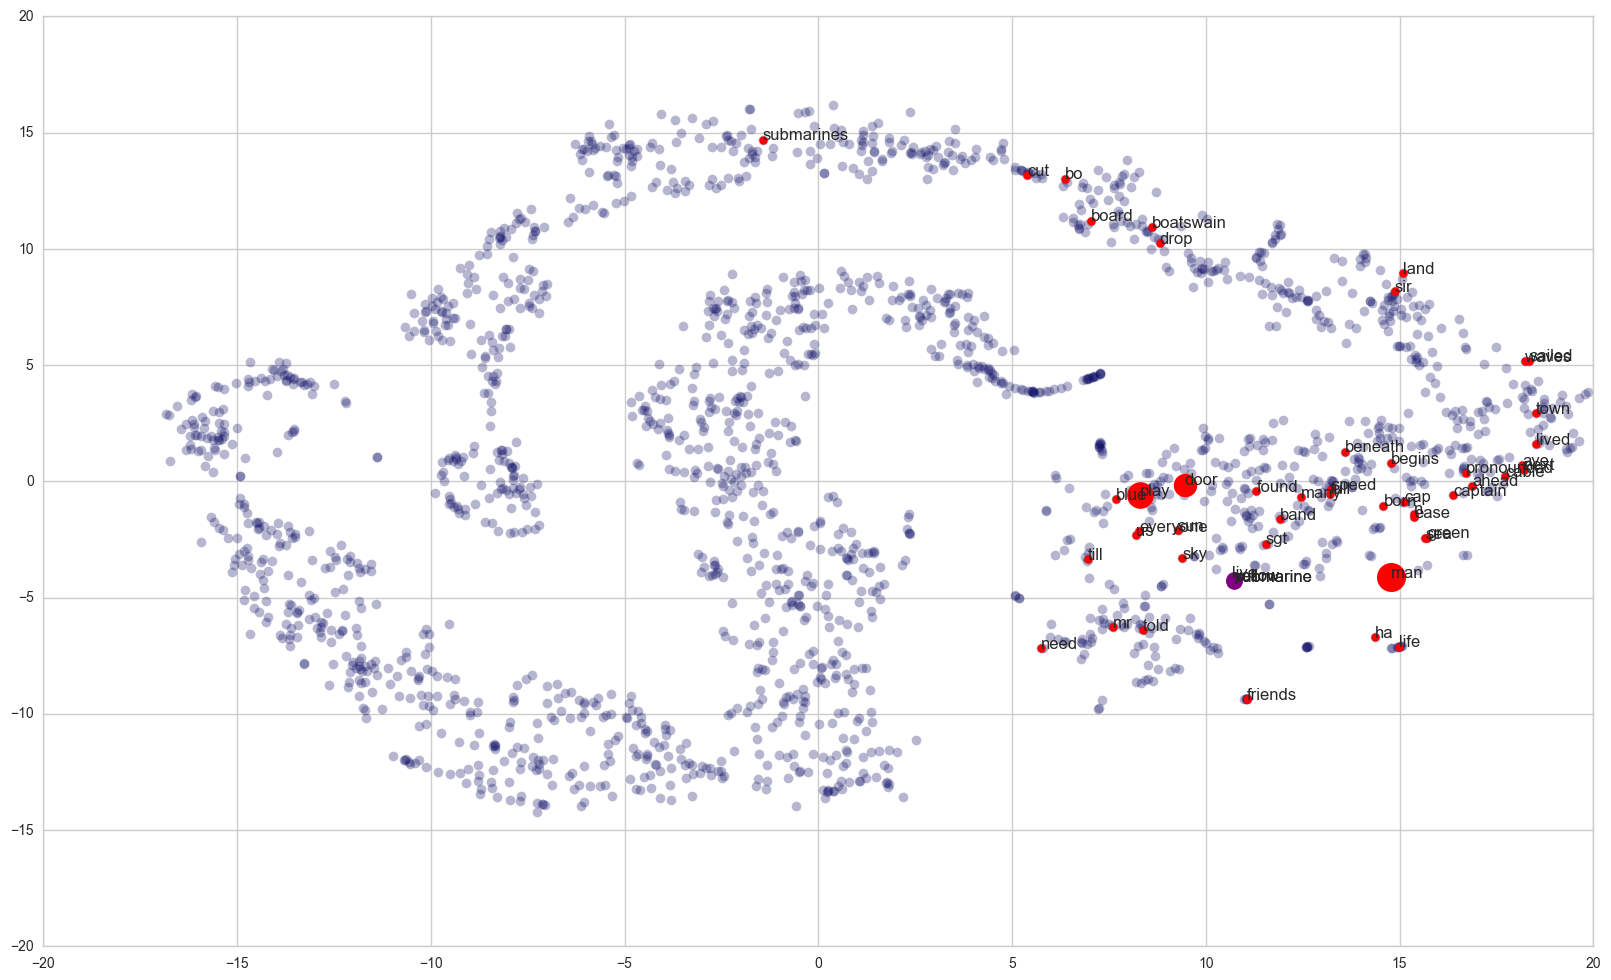

In [66]:
plot_word_vecs(word_vecs_50_2,w2v_words,word_search=['submarine','yellow'],song_search=['yellow submarine'],tfidf=True)

<a id='threed'></a>
### 3D word2vec plot
[back to top](#top)<br>

In [67]:
# importing plotly - might need to pip install

import plotly
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
from plotly.offline import download_plotlyjs, plot, iplot
#import plotly.plotly as py # for online use of plotly
import plotly.graph_objs as go

from plotly import __version__
print (__version__ )

1.12.9


In [68]:
# obtaining 3D vectors

word_vecs_50_3 = dim_reduct_pca_tsne(word_vectors,pca_components=50,tsne_components=3)

word_vecs_25_3 = dim_reduct_pca_tsne(word_vectors,pca_components=25,tsne_components=3)


In [69]:
# Simple 3D scatter plot of vectors

# Use 'iplot' to display plot in the notebook, or 'plot' to display it in browser
#   Sometimes 'iplot' is a bit finicky...

def plot_3d(word_vecs,words,filename):
    x = word_vecs[:,0]
    y = word_vecs[:,1]
    z = word_vecs[:,2]
    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        text=words,
        marker=dict(
            size=12,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
            ),
            opacity=0.8
        )
    )
    
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    plot(fig, filename=filename)  # comment out one or the other
    #iplot(fig, filename=filename)

In [70]:
plot_3d(word_vecs_50_3,w2v_words,'word_vecs_50_3.html')

In [71]:
plot_3d(word_vecs_25_3,w2v_words,'word_vecs_25_3.html')

Printed in browser. PCA to 50, then TSNE to 3 (word_vecs_50_3) seems to work the best.

Can still add song/word search functionality

<a id='csv'></a>
### CSV
Saving vectors to csv for use in JS and HTML.

[back to top](#top)<br>

In [72]:
# Saving 2-dimensional word vectors to csv

csv_2d_w2v = [list(row) for row in list(zip(w2v_words, word_vecs_50_2[:,0], word_vecs_50_2[:,1]))]

with open("beatles_2d_w2v.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(csv_2d_w2v)
    

In [73]:
# Saving 3-dimensional word vectors to csv

csv_3d_w2v = [list(row) for row in list(zip(w2v_words, word_vecs_50_3[:,0], word_vecs_50_3[:,1], word_vecs_50_3[:,2]))]

with open("beatles_3d_w2v.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(csv_3d_w2v)